In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from jax import config
config.update("jax_enable_x64", True)
device = "cpu"
config.update("jax_platform_name", device)

import os
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"]=".8"

import time
import pickle

import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np

import jax.numpy as jnp
from jax import jit, value_and_grad, vmap
import optax
import tensorflow as tf
import tensorflow_datasets as tfds
import jax

import jaxley as jx
from jaxley.channels import HH
from jaxley.utils.colors import network_cols

In [3]:
from neuron import h

_ = h.load_file("stdlib.hoc")
_ = h.load_file("import3d.hoc")

--No graphics will be displayed.


In [4]:
def compute_jx_rads_and_lengths(cell):
    jx_radiuses = []
    for a in cell.nodes.groupby("branch_index")["radius"].apply(list).to_numpy():
        jx_radiuses.append(a)
    jx_radiuses = np.asarray(jx_radiuses)
    
    jx_pathlengths = []
    for a in cell.nodes.groupby("branch_index")["length"].apply(list).to_numpy():
        jx_pathlengths.append(a)
    jx_pathlengths = np.asarray(jx_pathlengths)
    jx_pathlengths = np.sum(jx_pathlengths, axis=1)
    return jx_radiuses, jx_pathlengths

def build_corrected_rads(jx_pathlengths, neuron_pathlengths, neuron_radiuses):
    sorted_neuron_pathlenghts = []
    sorted_neuron_radiuses = []
    
    for jx_path in jx_pathlengths:
        argmin = np.argmin(np.abs(jx_path - neuron_pathlengths))
        sorted_neuron_pathlenghts.append(neuron_pathlengths[argmin])
        sorted_neuron_radiuses.append(neuron_radiuses[argmin])
    sorted_neuron_pathlenghts = np.asarray(sorted_neuron_pathlenghts)
    sorted_neuron_radiuses = np.asarray(sorted_neuron_radiuses)

    return sorted_neuron_radiuses, sorted_neuron_pathlenghts

In [16]:
site = "484559000"
recording_sites = {
    "485574832": [[0, 60, 68], [0.2, 0.6, 0.6], 160, [-400, 0], [-900, -100]],
    "480351780": [[0, 66, 71], [0.2, 0.4, 0.4], 220, [-850, -450], [-550, 450]],
    "484559000": [[0, 35, 37], [0.2, 0.2, 0.2], 155, [-350, 50], [-850, 150]],
    "488683425": [[0, 61, 63], [0.2, 0.6, 0.6], 198, [-750, -350], [-750, 250]],
}

fname = f"../../../nex/l5pc/cell_types/specimen_{site}/reconstruction.swc"
_, jx_pathlengths, _, _, _ = jx.utils.swc.swc_to_jaxley(fname, max_branch_len=5_000.0)

i_amp = 0.3

branches = recording_sites[site][0]
comps = recording_sites[site][1]
rotation = recording_sites[site][2]
xlim = recording_sites[site][3]
ylim = recording_sites[site][4]

nseg_per_branch = 4

i_delay = 1.0  # ms
i_dur = 2.0  # ms
dt = 0.025  # ms
t_max = 20.0  # ms

/Users/michaeldeistler/Documents/phd/jaxley/jaxley/utils/swc.py:185: UserWarning: Found a soma which consists of a single traced point. `Jaxley` interprets this soma as a spherical compartment with radius specified in the SWC file, i.e. with surface area 4*pi*r*r.
  warn(


In [17]:
test_cell = jx.read_swc(fname, nseg_per_branch, max_branch_len=5_000.0, assign_groups=True)
num_branches = len(test_cell.comb_parents)
# _ = np.random.seed(1)
# branch_radiuses = 0.1 + np.random.rand(num_branches)

In [18]:
from copy import deepcopy


def get_neuron_radius():
    for sec in h.allsec():
        h.delete_section(sec=sec)
        
    cell_neuron = h.Import3d_SWC_read()
    cell_neuron.input(fname)
    i3d = h.Import3d_GUI(cell_neuron, False)
    i3d.instantiate(None)
    
    for sec in h.allsec():
        sec.nseg = nseg_per_branch

    neuron_radiuses = []
    for i, sec in enumerate(h.allsec()):
        rads_in_sec = []
        for seg in sec:
            neuron_radiuses.append(seg.diam)
    neuron_radiuses = np.asarray(neuron_radiuses) / 2
    return neuron_radiuses


def simulate_neuron(i_amp, radiuses):
    for sec in h.allsec():
        h.delete_section(sec=sec)
        
    cell_neuron = h.Import3d_SWC_read()
    cell_neuron.input(fname)
    i3d = h.Import3d_GUI(cell_neuron, False)
    i3d.instantiate(None)
    
    for sec in h.allsec():
        sec.nseg = nseg_per_branch

    neuron_pathlengths = np.asarray([sec.L for sec in h.allsec()])

    neuron_to_jaxley_branch_mapping = []
    for i, p in enumerate(jx_pathlengths):
        closest_match = np.argmin(np.abs(neuron_pathlengths - p))
        max_dist = np.min(np.abs(neuron_pathlengths - p))
        assert max_dist < 2e-4, f"{i}, max_dist {max_dist}"
        neuron_to_jaxley_branch_mapping.append(closest_match)
    neuron_to_jaxley_branch_mapping = np.asarray(neuron_to_jaxley_branch_mapping)

    jaxley_to_neuron_branch_mapping = []
    for i, p in enumerate(neuron_pathlengths):
        closest_match = np.argmin(np.abs(jx_pathlengths - p))
        max_dist = np.min(np.abs(jx_pathlengths - p))
        assert max_dist < 2e-4, f"{i}, max_dist {max_dist}"
        jaxley_to_neuron_branch_mapping.append(closest_match)
    jaxley_to_neuron_branch_mapping = np.asarray(jaxley_to_neuron_branch_mapping)

    for branch_ind, sec in enumerate(h.allsec()):
        if branch_ind > 0:
            for comp, seg in enumerate(sec):
                seg.diam = 2 * radiuses[nseg_per_branch * branch_ind + comp]

    for i, sec in enumerate(h.allsec()):
        if i == 0:
            stim = h.IClamp(sec(0.2))
            stim.delay = i_delay
            stim.dur = i_dur
            stim.amp = i_amp
    
    counter = 0
    voltage_recs = {}

    for r, c in zip(neuron_to_jaxley_branch_mapping[branches], comps):
        for i, sec in enumerate(h.allsec()):
            if i == r:
                v = h.Vector()
                v.record(sec(c)._ref_v)
                voltage_recs[f"v{counter}"] = v
                counter += 1
    
    for sec in h.allsec():
        sec.insert("hh")
        sec.Ra = 1_000.0
    
        sec.gnabar_hh = 0.120  # S/cm2
        sec.gkbar_hh = 0.036  # S/cm2
        sec.gl_hh = 0.0003  # S/cm2
        sec.ena = 50  # mV
        sec.ek = -77.0  # mV
        sec.el_hh = -54.3  # mV
    
    h.dt = dt
    tstop = t_max
    v_init = -62.0
    
    def initialize():
        h.finitialize(v_init)
        h.fcurrent()
    
    def integrate():
        while h.t < tstop:
            h.fadvance()
    
    initialize()
    integrate()
    voltages_neuron = np.asarray([voltage_recs[key] for key in voltage_recs])
    return voltages_neuron, neuron_pathlengths, neuron_to_jaxley_branch_mapping, jaxley_to_neuron_branch_mapping

In [19]:
neuron_radiuses = get_neuron_radius()
for i_amp in np.arange(0.1, 1.11, 0.1):
    voltages_neuron, neuron_pathlengths, neuron_to_jaxley_branch_mapping, jaxley_to_neuron_branch_mapping = simulate_neuron(i_amp, neuron_radiuses)
    
    cell = jx.read_swc(fname, nseg_per_branch, max_branch_len=5_000.0, assign_groups=True)
    cell.rotate(rotation)
    cell.insert(HH())
    
    for b, c in zip(branches, comps):
        cell.branch(b).loc(c).record()
    
    cell.set("axial_resistivity", 1_000.0)
    cell.set("v", -62.0)
    cell.set("HH_m", 0.074901)
    cell.set("HH_h", 0.4889)
    cell.set("HH_n", 0.3644787)
    for branch_num in range(1, len(cell.comb_parents)):
        for comp in range(nseg_per_branch):
            cell.branch(branch_num).comp(comp).set("radius", neuron_radiuses[nseg_per_branch * neuron_to_jaxley_branch_mapping[branch_num] + comp])
    
    current = jx.step_current(i_delay, i_dur, i_amp, dt, t_max)
    cell.branch(0).loc(0.2).stimulate(current)
    
    # Run jaxley
    with jax.disable_jit():
        voltages_jaxley = jx.integrate(cell, delta_t=dt, voltage_solver="scipy")

    time_vec = jnp.arange(0, t_max+2*dt, dt)

    jaxley_argmax = np.argmax(voltages_jaxley, axis=1)
    neuron_argmax = np.argmax(voltages_neuron, axis=1)

    spike_times_jaxley = time_vec[jaxley_argmax]
    spike_times_neuron = time_vec[neuron_argmax]

    spike_amplitude_jaxley = np.asarray([v[j] for v, j in zip(voltages_jaxley, jaxley_argmax)])
    spike_amplitude_neuron = np.asarray([v[j] for v, j in zip(voltages_neuron, neuron_argmax)])
    print("Error in amplitude: ", np.abs(spike_amplitude_jaxley - spike_amplitude_neuron))
    print("Error in timing: ", np.abs(spike_times_jaxley - spike_times_neuron))

/Users/michaeldeistler/Documents/phd/jaxley/jaxley/utils/swc.py:185: UserWarning: Found a soma which consists of a single traced point. `Jaxley` interprets this soma as a spherical compartment with radius specified in the SWC file, i.e. with surface area 4*pi*r*r.
  warn(


Added 1 recordings. See `.recordings` for details.
Added 1 recordings. See `.recordings` for details.
Added 1 recordings. See `.recordings` for details.
Added 1 external_states. See `.externals` for details.
Error in amplitude:  [0.01201973 0.00998622 0.01596947]
Error in timing:  [0. 0. 0.]
Added 1 recordings. See `.recordings` for details.
Added 1 recordings. See `.recordings` for details.
Added 1 recordings. See `.recordings` for details.


/Users/michaeldeistler/Documents/phd/jaxley/jaxley/utils/swc.py:185: UserWarning: Found a soma which consists of a single traced point. `Jaxley` interprets this soma as a spherical compartment with radius specified in the SWC file, i.e. with surface area 4*pi*r*r.
  warn(


Added 1 external_states. See `.externals` for details.
Error in amplitude:  [0.01140331 0.00333559 0.00392687]
Error in timing:  [0.025 0.025 0.   ]
Added 1 recordings. See `.recordings` for details.
Added 1 recordings. See `.recordings` for details.
Added 1 recordings. See `.recordings` for details.


/Users/michaeldeistler/Documents/phd/jaxley/jaxley/utils/swc.py:185: UserWarning: Found a soma which consists of a single traced point. `Jaxley` interprets this soma as a spherical compartment with radius specified in the SWC file, i.e. with surface area 4*pi*r*r.
  warn(


Added 1 external_states. See `.externals` for details.
Error in amplitude:  [0.01641842 0.01391564 0.00305721]
Error in timing:  [0.    0.025 0.   ]
Added 1 recordings. See `.recordings` for details.
Added 1 recordings. See `.recordings` for details.
Added 1 recordings. See `.recordings` for details.


/Users/michaeldeistler/Documents/phd/jaxley/jaxley/utils/swc.py:185: UserWarning: Found a soma which consists of a single traced point. `Jaxley` interprets this soma as a spherical compartment with radius specified in the SWC file, i.e. with surface area 4*pi*r*r.
  warn(


Added 1 external_states. See `.externals` for details.
Error in amplitude:  [0.01735457 0.00367103 0.00029447]
Error in timing:  [0. 0. 0.]
Added 1 recordings. See `.recordings` for details.
Added 1 recordings. See `.recordings` for details.
Added 1 recordings. See `.recordings` for details.


/Users/michaeldeistler/Documents/phd/jaxley/jaxley/utils/swc.py:185: UserWarning: Found a soma which consists of a single traced point. `Jaxley` interprets this soma as a spherical compartment with radius specified in the SWC file, i.e. with surface area 4*pi*r*r.
  warn(


Added 1 external_states. See `.externals` for details.
Error in amplitude:  [0.02553764 0.01878273 0.00055199]
Error in timing:  [0. 0. 0.]
Added 1 recordings. See `.recordings` for details.
Added 1 recordings. See `.recordings` for details.
Added 1 recordings. See `.recordings` for details.


/Users/michaeldeistler/Documents/phd/jaxley/jaxley/utils/swc.py:185: UserWarning: Found a soma which consists of a single traced point. `Jaxley` interprets this soma as a spherical compartment with radius specified in the SWC file, i.e. with surface area 4*pi*r*r.
  warn(


Added 1 external_states. See `.externals` for details.
Error in amplitude:  [0.02351719 0.01488076 0.00131874]
Error in timing:  [0. 0. 0.]
Added 1 recordings. See `.recordings` for details.
Added 1 recordings. See `.recordings` for details.
Added 1 recordings. See `.recordings` for details.


/Users/michaeldeistler/Documents/phd/jaxley/jaxley/utils/swc.py:185: UserWarning: Found a soma which consists of a single traced point. `Jaxley` interprets this soma as a spherical compartment with radius specified in the SWC file, i.e. with surface area 4*pi*r*r.
  warn(


Added 1 external_states. See `.externals` for details.
Error in amplitude:  [0.03164776 0.00376709 0.00195496]
Error in timing:  [0. 0. 0.]
Added 1 recordings. See `.recordings` for details.
Added 1 recordings. See `.recordings` for details.
Added 1 recordings. See `.recordings` for details.


/Users/michaeldeistler/Documents/phd/jaxley/jaxley/utils/swc.py:185: UserWarning: Found a soma which consists of a single traced point. `Jaxley` interprets this soma as a spherical compartment with radius specified in the SWC file, i.e. with surface area 4*pi*r*r.
  warn(


Added 1 external_states. See `.externals` for details.
Error in amplitude:  [0.03304312 0.00838984 0.00326951]
Error in timing:  [0. 0. 0.]
Added 1 recordings. See `.recordings` for details.
Added 1 recordings. See `.recordings` for details.
Added 1 recordings. See `.recordings` for details.


/Users/michaeldeistler/Documents/phd/jaxley/jaxley/utils/swc.py:185: UserWarning: Found a soma which consists of a single traced point. `Jaxley` interprets this soma as a spherical compartment with radius specified in the SWC file, i.e. with surface area 4*pi*r*r.
  warn(


Added 1 external_states. See `.externals` for details.
Error in amplitude:  [0.03912076 0.02335439 0.00478326]
Error in timing:  [0. 0. 0.]
Added 1 recordings. See `.recordings` for details.
Added 1 recordings. See `.recordings` for details.
Added 1 recordings. See `.recordings` for details.


/Users/michaeldeistler/Documents/phd/jaxley/jaxley/utils/swc.py:185: UserWarning: Found a soma which consists of a single traced point. `Jaxley` interprets this soma as a spherical compartment with radius specified in the SWC file, i.e. with surface area 4*pi*r*r.
  warn(


Added 1 external_states. See `.externals` for details.
Error in amplitude:  [0.03541422 0.01421699 0.01312158]
Error in timing:  [0. 0. 0.]
Added 1 recordings. See `.recordings` for details.
Added 1 recordings. See `.recordings` for details.
Added 1 recordings. See `.recordings` for details.


/Users/michaeldeistler/Documents/phd/jaxley/jaxley/utils/swc.py:185: UserWarning: Found a soma which consists of a single traced point. `Jaxley` interprets this soma as a spherical compartment with radius specified in the SWC file, i.e. with surface area 4*pi*r*r.
  warn(


Added 1 external_states. See `.externals` for details.
Error in amplitude:  [0.04442836 0.01160558 0.01339651]
Error in timing:  [0.025 0.    0.   ]


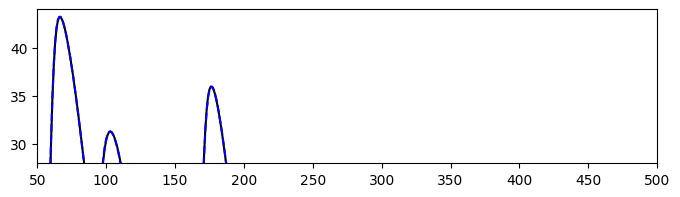

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(8, 2))
_ = ax.plot(voltages_neuron.T, c="k")
_ = ax.plot(voltages_jaxley.T, c="blue", linestyle="--")
_ = ax.set_ylim([28, 44])
_ = ax.set_xlim([50, 500])
plt.show()